# ALUNOS: 

- Aluno1: André Noronha Salles Miranda Martins
- Aluno2: Igor felippe muzel kalomenconkovas


# CIÊNCIA DE DADOS

## Etapas previstas para realizar Análise Exploratória dos Dados:
- Importar as bibliotecas necessárias 
- Separar as variáveis de input (independentes) e o target (alvo, objetivo)
- Separar a base em treino e teste
- Definir os algoritmos a serem testados
- Criar o classificador
- Treinar o modelo com a base de treino
- Avaliar o r2
- Predizer o modelo com a base de teste
- Avaliar os resultados obtidos
- Comparar os modelos
- Apresentar os resultados

## Análise de Perfil de risco de Beneficiários

O desafio consiste na **análise de perfil de risco de beneficiários com predição, analise de custo evitado e alertas de possíveis candidatos a doenças crônicas**, segundo a Portaria nº 483, de 1º de abril de 2014, as doenças crônicas são aquelas que apresentam início gradual, com duração longa ou incerta, que, em geral, apresentam múltiplas causas e cujo tratamento envolva mudanças de estilo de vida, em um processo de cuidado contínuo. Segundo a OMS as principais doenças crônicas não transmissíveis, (DCNT), um exemplo são:
- Doenças cerebrovasculares
- Doenças cardiovasculares
- Diabetes mellitus
- Doenças respiratórias crônicas (asma)
- Neoplasias (câncer)
- Obesidade
- Hipertensão

Na Unimed Ponta Grossa, temos o programa de acompanhamento linha de cuidado, em que os beneficiários identificados com as DCNT são acompanhados.

Para as análises e ETLs serão disponibilizadas informações referentes a utilização do plano de saúde por todos os beneficiários, procedimentos executados, dados do perfil de usuário, entradas em pronto atendimento e internação (em uma base separada para ser relacionada por id de pessoa). Também serão indicados os pacientes que já possuem diagnóstico de DCNT e já são acompanhados pela equipe de linha e cuidado e o tempo de acompanhamento. 

O **objetivo** é construir um modelo capaz calcular o custo evitado dos pacientes que estão no programa, identificar pacientes com maior probabilidade de desenvolver DCTNs ou que já possam estar com alguma DCNTs e não fazem parte da nossa linha de cuidado, com base em seus perfis e históricos médicos.

Resultados Esperados:
- Tratamento das informações
- Relacionamento entre o Datasets
- Identificação de padrões para cada grupo
- Alertas de possíveis pacientes com DCNTs
- Predição de possíveis casos:
- Resultado de custo Evitado (custo do paciente antes de entrar no programa e após a entrada no programa)
- Predição de custo evitado de pacientes que ainda não fazem parte do programa
Bônus: outras analises não indicadas acima
**Obs: na analise de custo evitado, levar em conta a correção monetária dos anos anteriores
 
Dados Gerais
- ID de usuário
- Data de nascimento
- Sexo
- Peso
- Número de Gestações
- Grau de dependência (Se Titular)
- Contratante
- Tipo de Plano
- Procedimentos Realizados
- Data do procedimento
- Especialidade do executante
- Especialidade do solicitante
- Paciente faz parte da linha de cuidado
- Programa que o paciente faz parte

Dados de PA e Internação (somente Beneficiários):
- ID do atendimento
- Data/hora da entrada
- Procedimento principal do atendimento
- CID
- Queixa
- Observação
- Clínica (tipo de atendimento)
- Especialidade Médico Responsável
- Classificação de Risco (Manchester)
- Data/hora da Internação
- Motivo da Alta
- Data da alta

# Importar e visualizar a base

In [1]:
# Importar as bibliotecas necessárias para solucionar o probema
import pandas as pd

In [2]:
# Importar a base de dados
cid_paciente = pd.read_excel("base_tratadas/cid_paciente.xlsx", sheet_name=None, index_col=None)
cid_paciente = pd.concat(cid_paciente.values(), ignore_index=True)
custo_beneficiario = pd.read_excel("base_tratadas/custo_beneficiario.xlsx", sheet_name=None, index_col=None)
custo_beneficiario = pd.concat(custo_beneficiario.values(), ignore_index=True)
at_hgu = pd.read_excel("base_tratadas/at_hgu.xlsx", sheet_name=None, index_col=None)
at_hgu = pd.concat(at_hgu.values(), ignore_index=True)
cid_atendimento = pd.read_excel("base_tratadas/cid_atendimento.xlsx")
lc_beneficiario = pd.read_excel("base_tratadas/lc_beneficiario.xlsx")
lc_cid = pd.read_excel("base_tratadas/lc_cid.xlsx")
beneficiario_hgu = pd.read_excel("base_tratadas/beneficiario_hgu.xlsx")
procedimento_lc = pd.read_excel("base_tratadas/procedimento_lc.xlsx")
procedimentos = pd.read_excel("base_tratadas/procedimentos.xlsx")

In [3]:
# Tratamento para gerar as bases para os algoritmos de aprendizado de máquina
cid_paciente.drop(columns=['dt_entrada', 'dt_alta', 'qt_peso', 'ds_especialidade_medico_responsavel', 'ds_motivo_alta', 'ds_tipo_atendimento', 'ds_clinica'], inplace=True)

custo_beneficiario.drop(columns=['qt_idade', 'ds_estado_civil', 'vl_item'], inplace=True)

at_hgu.drop(columns=['dt_entrada', 'dt_alta', 'ds_especialidade_medico_responsavel', 'ds_motivo_alta', 'ds_tipo_atendimento', 'ds_clinica'], inplace=True)

cid_atendimento.drop(columns=['dt_entrada', 'dt_alta', 'ds_especialidade_medico_responsavel', 'ds_motivo_alta', 'ds_tipo_atendimento', 'ds_clinica'], inplace=True)

lc_beneficiario.drop(columns=['qt_idade', 'ds_estado_civil'], inplace=True)

beneficiario_hgu.drop(columns=['ds_plano', 'qt_idade_x', 'ds_estado_civil', 'qt_imc', 'cd_sexo'], inplace=True)

procedimento_lc.drop(columns=['ds_grupo', 'ds_subgrupo'], inplace=True)

procedimentos.drop(columns=['ds_grupo', 'ds_classificacao'], inplace=True)

In [56]:
# Merges para criar as bases a serem aplicadas nos algortimos
dcnt = pd.merge(beneficiario_hgu, cid_paciente, how='left', on='id_beneficiario')
dcnt.merge(lc_beneficiario, how='right', on='id_beneficiario')

proc = pd.merge(procedimentos, procedimento_lc, how='left', on='id_item')

atend = pd.merge(cid_atendimento, at_hgu, how='left', on='id_paciente')

atend = atend.drop_duplicates(subset=['nr_atendimento'])
lc_cid = lc_cid.drop_duplicates(subset=['nr_atendimento'])

atend = atend.merge(lc_cid, how='left', on='nr_atendimento')
atend = atend.merge(proc, how='left', on='id_item')

custo = pd.merge(custo_beneficiario, atend, how='left', on='ds_item')

In [57]:
# Visualizar as bases
display(dcnt)

,id_beneficiario,qt_altura_cm_x,qt_peso,faixa_etaria,plano_agrupado,faixa_imc,sexo_legivel,qt_idade,qt_imc,qt_altura_cm_y,cd_sexo,ds_linha_cuidado,ds_cid,faixa_peso,ano_entrada
0,143274,165.0,65.0,50-59,Outros,Peso normal,Feminino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,138347,165.0,75.0,50-59,Outros,Sobrepeso,Feminino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,143358,170.0,70.0,40-49,Outros,Peso normal,Feminino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,168425,153.0,65.0,10-19,Outros,Sobrepeso,Masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,141026,162.0,88.0,40-49,Outros,Obesidade I,Feminino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929263,215685,144.0,34.0,10-19,Coletivo Empresarial Regional Apartamento,Abaixo do peso,Masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2929264,524273,173.0,127.0,30-39,Coletivo Empresarial Regional Apartamento,Obesidade III,Masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2929265,184186,166.0,83.0,40-49,Coletivo Empresarial Regional Apartamento,Obesidade I,Feminino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2929266,177610,168.0,72.0,30-39,Coletivo Empresarial Regional Apartamento,Sobrepeso,Masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
display(custo)

,ds_plano,ds_sexo,ds_item,faixa_idade,faixa_gasto,faixa_vl_item,nr_atendimento,cd_doenca,ds_linha_cuidado_x,id_paciente,ano_entrada,id_item,qt_item,ds_linha_cuidado_y,ds_cid,ds_origem_item,ds_item_x,ds_item_y,ds_linha_cuidado,id_linha_cuidado
0,FAMILIAR - REFERÊNCIA,Feminino,Tonometria - Binocular,50-64,0-100,0-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FAMILIAR - REFERÊNCIA,Feminino,Coluna Cervical Ou Dorsal Ou Lombar,50-64,501-1000,500-1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FAMILIAR - REFERÊNCIA,Feminino,Procedimento Diagnóstico Em Peça Anatômica O,50-64,0-100,0-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FAMILIAR - REFERÊNCIA,Feminino,Em Consultório (No Horário Normal Ou Preestabe...,50-64,101-500,100-500,2369129.0,A90,Acidente Vascular Cerebral,665919.0,2024.0,6.900510e+12,1.0,Acidente Vascular Cerebral,Dengue,CBHPM,Em Consultório (no Horário Normal Ou Preestabe...,NaN,NaN,NaN
4,FAMILIAR - REFERÊNCIA,Feminino,Em Consultório (No Horário Normal Ou Preestabe...,50-64,101-500,100-500,2323765.0,E10,Diabetes,1048392.0,2024.0,6.900510e+12,1.0,Diabetes,Diabetes mellitus insulino-dependente - C/coma,CBHPM,Em Consultório (no Horário Normal Ou Preestabe...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25234722,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,2430947.0,A90,Acidente Vascular Cerebral,930637.0,2024.0,6.900510e+12,1.0,Acidente Vascular Cerebral,Dengue,CBHPM,Em Consultório (no Horário Normal Ou Preestabe...,NaN,NaN,NaN
25234723,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,2614009.0,A90,Acidente Vascular Cerebral,852478.0,2024.0,6.900510e+12,1.0,Acidente Vascular Cerebral,Dengue,CBHPM,Em Consultório (no Horário Normal Ou Preestabe...,NaN,NaN,NaN
25234724,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,2618623.0,E10,Diabetes,1044165.0,2024.0,6.900510e+12,1.0,Diabetes,Diabetes mellitus insulino-dependente - C/coma,CBHPM,Em Consultório (no Horário Normal Ou Preestabe...,NaN,NaN,NaN
25234725,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,2639754.0,E109,Diabetes,1036759.0,2025.0,6.900510e+12,1.0,Diabetes,Diabetes mellitus insulino-dependente - C/coma,CBHPM,Em Consultório (no Horário Normal Ou Preestabe...,NaN,NaN,NaN


In [59]:
dcnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929268 entries, 0 to 2929267
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   id_beneficiario   int64  
 1   qt_altura_cm_x    float64
 2   qt_peso           float64
 3   faixa_etaria      object 
 4   plano_agrupado    object 
 5   faixa_imc         object 
 6   sexo_legivel      object 
 7   qt_idade          float64
 8   qt_imc            float64
 9   qt_altura_cm_y    float64
 10  cd_sexo           object 
 11  ds_linha_cuidado  object 
 12  ds_cid            object 
 13  faixa_peso        object 
 14  ano_entrada       float64
dtypes: float64(6), int64(1), object(8)
memory usage: 335.2+ MB


In [60]:
custo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25234727 entries, 0 to 25234726
Data columns (total 20 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ds_plano            object 
 1   ds_sexo             object 
 2   ds_item             object 
 3   faixa_idade         object 
 4   faixa_gasto         object 
 5   faixa_vl_item       object 
 6   nr_atendimento      float64
 7   cd_doenca           object 
 8   ds_linha_cuidado_x  object 
 9   id_paciente         float64
 10  ano_entrada         float64
 11  id_item             float64
 12  qt_item             float64
 13  ds_linha_cuidado_y  object 
 14  ds_cid              object 
 15  ds_origem_item      object 
 16  ds_item_x           object 
 17  ds_item_y           object 
 18  ds_linha_cuidado    object 
 19  id_linha_cuidado    float64
dtypes: float64(6), object(14)
memory usage: 3.8+ GB


In [61]:
# Tratar base apos o merge
dcnt = dcnt.drop(['id_beneficiario', 'qt_idade', 'qt_imc', 'qt_altura_cm_y', 'cd_sexo', 'qt_peso'], axis=1)
dcnt = dcnt.dropna()
dcnt = dcnt.drop_duplicates()

In [62]:
custo = custo.drop(['nr_atendimento', 'id_paciente', 'id_item', 'ds_linha_cuidado_y', 'ds_item_x', 'ds_item_y', 'ds_linha_cuidado', 'id_linha_cuidado', 'ds_cid'], axis=1)
custo = custo.dropna()
custo = custo.drop_duplicates()

## Visualizando um resumo das informações


In [63]:
# Verificando o domínio dos dados
dcnt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 422226 entries, 36 to 2929056
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   qt_altura_cm_x    422226 non-null  float64
 1   faixa_etaria      422226 non-null  object 
 2   plano_agrupado    422226 non-null  object 
 3   faixa_imc         422226 non-null  object 
 4   sexo_legivel      422226 non-null  object 
 5   ds_linha_cuidado  422226 non-null  object 
 6   ds_cid            422226 non-null  object 
 7   faixa_peso        422226 non-null  object 
 8   ano_entrada       422226 non-null  float64
dtypes: float64(2), object(7)
memory usage: 32.2+ MB


In [64]:
custo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198163 entries, 3 to 25234726
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ds_plano            198163 non-null  object 
 1   ds_sexo             198163 non-null  object 
 2   ds_item             198163 non-null  object 
 3   faixa_idade         198163 non-null  object 
 4   faixa_gasto         198163 non-null  object 
 5   faixa_vl_item       198163 non-null  object 
 6   cd_doenca           198163 non-null  object 
 7   ds_linha_cuidado_x  198163 non-null  object 
 8   ano_entrada         198163 non-null  float64
 9   qt_item             198163 non-null  float64
 10  ds_origem_item      198163 non-null  object 
dtypes: float64(2), object(9)
memory usage: 18.1+ MB


In [65]:
dcnt['ano_entrada'] = pd.to_datetime(dcnt['ano_entrada'], errors='coerce')

for col in dcnt.select_dtypes(include='object').columns:
    dcnt[col] = dcnt[col].astype('category')

In [66]:
custo['ano_entrada'] = pd.to_datetime(custo['ano_entrada'], errors='coerce')
custo['qt_item'] = custo['qt_item'].astype('Int64')

for col in custo.select_dtypes(include='object').columns:
    custo[col] = custo[col].astype('category')

# **Conclusão: identifique quais colunas (variáveis) seriam utilizadas em um modelo de aprendizagem de máquina**
## **Relevantes para Previsão** obtidas após a realização da análise exploratória


In [ ]:
# Apresente as colunas a sere utilizando na versão final do Projeto UNIMED

In [ ]:
# DCNT
#  0   qt_altura_cm_x    422226 non-null  float64       
#  1   faixa_etaria      422226 non-null  category      
#  2   plano_agrupado    422226 non-null  category      
#  3   faixa_imc         422226 non-null  category      
#  4   sexo_legivel      422226 non-null  category      
#  5   ds_linha_cuidado  422226 non-null  category      
#  6   ds_cid            422226 non-null  category      
#  7   faixa_peso        422226 non-null  category      
#  8   ano_entrada       422226 non-null  datetime64[ns]

In [ ]:
# CUSTO
#  0   ds_plano            198163 non-null  category      
#  1   ds_sexo             198163 non-null  category      
#  2   ds_item             198163 non-null  category      
#  3   faixa_idade         198163 non-null  category      
#  4   faixa_gasto         198163 non-null  category      
#  5   faixa_vl_item       198163 non-null  category      
#  6   cd_doenca           198163 non-null  category      
#  7   ds_linha_cuidado_x  198163 non-null  category      
#  8   ano_entrada         198163 non-null  datetime64[ns]
#  9   qt_item             198163 non-null  Int64         
#  10  ds_origem_item      198163 non-null  category

In [ ]:
# Apresente as colunas eliminadas da versão final do Projeto UNIMED

In [ ]:
# DCNT
# id_beneficiario qt_idade
# qt_imc
# qt_altura_cm_y
# cd_sexo
# qt_peso

In [ ]:
# CUSTO
# nr_atendimento
# id_paciente
# id_item
# ds_linha_cuidado_y
# ds_item_x
# ds_item_y
# ds_linha_cuidado
# id_linha_cuidado

# PROJETO FINAL DE CIÊNCIA DE DADOS

Resultados Esperados:
- Tratamento das informações
- Relacionamento entre o Datasets
- Identificação de padrões para cada grupo
- Alertas de possíveis pacientes com DCNTs
- Predição de possíveis casos:
- Resultado de custo Evitado (custo do paciente antes de entrar no programa e após a entrada no programa)
- Predição de custo evitado de pacientes que ainda não fazem parte do programa
Bônus: outras analises não indicadas acima
**Obs: na analise de custo evitado, levar em conta a correção monetária dos anos anteriores


## Aprendizado de Máquina

- Definir 3 algorítmos de aprendizado de máquina a ser testado no Desafio

In [263]:
# Importar as bibliotecas necessárias para o aprendizado
import matplotlib.pyplot as plt
import numpy as np
import re
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [241]:
# Criar a variável alvo 'doenca_cronica', para base DCNT
cronico_por_cid = dcnt['ds_cid'].str.contains('diabetes|hipertens|obesidade', case=False, na=False)
cronico_por_imc = dcnt['faixa_imc'].str.contains('Obesidade', case=False, na=False)
dcnt['doenca_cronica'] = (cronico_por_cid | cronico_por_imc).astype(int)

# Definir Features (X) e Alvo (y)
features = ['qt_altura_cm_x', 'faixa_etaria', 'plano_agrupado', 'sexo_legivel', 'ds_linha_cuidado']
X_d = dcnt[features]
y_d = dcnt['doenca_cronica']

In [242]:
# Definir o pré-processador para DCNT
faixa_etaria_cats = sorted(list(X_d['faixa_etaria'].unique()))
# faixa_imc_cats não é mais necessário aqui
ordinal_features = ['faixa_etaria'] # Apenas faixa_etaria agora é ordinal
nominal_features = ['plano_agrupado', 'sexo_legivel', 'ds_linha_cuidado']

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories=[faixa_etaria_cats]), ordinal_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ],
    remainder='passthrough'
)

In [67]:
# Criação da variavel target para custo

# Função para extrair o ponto‑médio de uma string de faixa
def midpoint(faixa_str):
    nums = re.findall(r"\d+\.?\d*", faixa_str.replace("R$", "").replace(",", "."))
    if len(nums) == 2:
        low, high = map(float, nums)
        return (low + high) / 2
    elif len(nums) == 1:
        return float(nums[0])
    else:
        return np.nan

# Calcular custo real a partir de 'faixa_gasto'
custo["custo_real"] = custo["faixa_gasto"].apply(midpoint).astype(float)

# Calcular valor médio por item e custo projetado
custo["vl_medio_item"] = custo["faixa_vl_item"].apply(midpoint).astype(float)
custo["custo_projetado"] = custo["vl_medio_item"] * custo["qt_item"]

# Gerar coluna 'custo_evitado'
custo["custo_evitado"] = custo["custo_projetado"] - custo["custo_real"]

# Evitar valores negativos
custo["custo_evitado"] = custo["custo_evitado"].clip(lower=0)

display(custo)

,ds_plano,ds_sexo,ds_item,faixa_idade,faixa_gasto,faixa_vl_item,cd_doenca,ds_linha_cuidado_x,ano_entrada,qt_item,ds_origem_item,custo_real,vl_medio_item,custo_projetado,custo_evitado
3,FAMILIAR - REFERÊNCIA,Feminino,Em Consultório (No Horário Normal Ou Preestabe...,50-64,101-500,100-500,A90,Acidente Vascular Cerebral,1970-01-01 00:00:00.000002024,1,CBHPM,300.5,300.0,300.0,0.0
4,FAMILIAR - REFERÊNCIA,Feminino,Em Consultório (No Horário Normal Ou Preestabe...,50-64,101-500,100-500,E10,Diabetes,1970-01-01 00:00:00.000002024,1,CBHPM,300.5,300.0,300.0,0.0
5,FAMILIAR - REFERÊNCIA,Feminino,Em Consultório (No Horário Normal Ou Preestabe...,50-64,101-500,100-500,E11,Diabetes,1970-01-01 00:00:00.000002024,1,CBHPM,300.5,300.0,300.0,0.0
29,FAMILIAR - REFERÊNCIA,Feminino,Em Consultório (No Horário Normal Ou Preestabe...,50-64,101-500,100-500,E119,Diabetes,1970-01-01 00:00:00.000002024,1,CBHPM,300.5,300.0,300.0,0.0
30,FAMILIAR - REFERÊNCIA,Feminino,Em Consultório (No Horário Normal Ou Preestabe...,50-64,101-500,100-500,E11,Diabetes,1970-01-01 00:00:00.000002025,1,CBHPM,300.5,300.0,300.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25234673,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,E119,Diabetes,1970-01-01 00:00:00.000002024,1,CBHPM,300.5,300.0,300.0,0.0
25234674,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,E11,Diabetes,1970-01-01 00:00:00.000002025,1,CBHPM,300.5,300.0,300.0,0.0
25234676,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,E10,Diabetes,1970-01-01 00:00:00.000002025,1,CBHPM,300.5,300.0,300.0,0.0
25234725,INSTITUCIONAL - VISITA UNIMED PLENO,Masculino,Em Consultório (No Horário Normal Ou Preestabe...,0-17,101-500,100-500,E109,Diabetes,1970-01-01 00:00:00.000002025,1,CBHPM,300.5,300.0,300.0,0.0


In [68]:
custo["ano_entrada"] = custo["ano_entrada"].dt.year

In [186]:
# Definir as variáveis de input e a target
y = custo["custo_evitado"]
X = custo.drop(columns=["custo_evitado"])

In [ ]:
# Dividir a base de dados em treino e teste para o custo
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [244]:
# Dividir os dados com estratificação para DCNT
X_train_d, X_test, y_train_d, y_test = train_test_split(X_d, y_d, test_size=0.3, random_state=42, stratify=y_d)

## Treinar, Predizer e Avaliar os Modelos

### Para Doença

#### Regressão logística

In [ ]:
#Regressão Logistica

# Criar o classificador
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

In [246]:
# Treinar o modelo
pipeline_lr.fit(X_train_d, y_train_d)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['0-9',
                                                                              '10-19',
                                                                              '20-29',
                                                                              '30-39',
                                                                              '40-49',
                                                                              '50-59',
                                                                              '60-69',
                                                                              '70-79',
                                                                              '80+']]),
                                                  ['faixa_etaria']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['plano_agrupado',
                                                   'sexo_legivel',
                                                   'ds_linha_cuidado'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [247]:
# Predizer o modelo
y_pred_lr = pipeline_lr.predict(X_test)

In [248]:
# Avaliar o modelo
print("Relatório de Classificação Regressão:")
print(classification_report(y_test, y_pred_lr))
print("-" * 50)

Relatório de Classificação Regressão:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62     63993
           1       0.60      0.50      0.55     62675

    accuracy                           0.59    126668
   macro avg       0.59      0.59      0.59    126668
weighted avg       0.59      0.59      0.59    126668

--------------------------------------------------


#### RandomForest

In [249]:
#Random Forest

# Criar o classificador
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

In [250]:
# Treinar o modelo
pipeline_rf.fit(X_train_d, y_train_d)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['0-9',
                                                                              '10-19',
                                                                              '20-29',
                                                                              '30-39',
                                                                              '40-49',
                                                                              '50-59',
                                                                              '60-69',
                                                                              '70-79',
                                                                              '80+']]),
                                                  ['faixa_etaria']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['plano_agrupado',
                                                   'sexo_legivel',
                                                   'ds_linha_cuidado'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [251]:
# Predizer o modelo
y_pred_rf = pipeline_rf.predict(X_test)

In [252]:
# Avaliar o modelo
print("Relatório de Classificação Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("-" * 50)

Relatório de Classificação Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     63993
           1       0.83      0.75      0.79     62675

    accuracy                           0.80    126668
   macro avg       0.80      0.80      0.80    126668
weighted avg       0.80      0.80      0.80    126668

--------------------------------------------------


#### LightGBM

In [253]:
#LightGBM
# Criar o classificador

pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(random_state=42, is_unbalance=True))
])

In [254]:
# Treinar o modelo
pipeline_lgbm.fit(X_train_d, y_train_d)

[LightGBM] [Info] Number of positive: 146242, number of negative: 149316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 295558, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494800 -> initscore=-0.020802
[LightGBM] [Info] Start training from score -0.020802


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  OrdinalEncoder(categories=[['0-9',
                                                                              '10-19',
                                                                              '20-29',
                                                                              '30-39',
                                                                              '40-49',
                                                                              '50-59',
                                                                              '60-69',
                                                                              '70-79',
                                                                              '80+']]),
                                                  ['faixa_etaria']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['plano_agrupado',
                                                   'sexo_legivel',
                                                   'ds_linha_cuidado'])])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True, random_state=42))])

In [255]:
# Predizer o modelo
y_pred_lgbm = pipeline_lgbm.predict(X_test)

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [256]:
# Avaliar o modelo
print("Relatório de Classificação LighGBM:")
print(classification_report(y_test, y_pred_lgbm))
print("-" * 50)

Relatório de Classificação LighGBM:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80     63993
           1       0.83      0.71      0.77     62675

    accuracy                           0.79    126668
   macro avg       0.79      0.79      0.78    126668
weighted avg       0.79      0.79      0.78    126668

--------------------------------------------------


### Para Custo

#### CatBoostRegressor

In [ ]:
# Criar o classificador
# Índices das colunas categóricas no X
cat_features = [X.columns.get_loc(col) for col in [
    "ds_plano", "ds_sexo", "ds_item", "faixa_idade",
    "faixa_gasto", "faixa_vl_item", "cd_doenca",
    "ds_linha_cuidado_x", "ds_origem_item"
]]

model_cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    eval_metric="RMSE",
    random_seed=42,
    verbose=100
)

In [77]:
# Treinar o modelo
# treino com early stopping
model_cb.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50
)

0:	learn: 559.5847330	test: 514.3246819	best: 514.3246819 (0)	total: 140ms	remaining: 2m 19s
100:	learn: 4.3447085	test: 38.2726820	best: 38.2535004 (99)	total: 6.12s	remaining: 54.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 38.23698187
bestIteration = 112

Shrink model to first 113 iterations.


In [78]:
# Predizer o modelo
y_pred_cb = model_cb.predict(X_val)

In [79]:
# Avaliar o modelo
print("CatBoost MAE:", mean_absolute_error(y_val, y_pred_cb))
print("CatBoost RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_cb)))
print("CatBoost R²:", r2_score(y_val, y_pred_cb))

CatBoost MAE: 0.41759787865467307
CatBoost RMSE: 38.236981872365355
CatBoost R²: 0.9949933492807155


#### XGBoostRegressor

In [224]:
# Criar o classificador
cat_cols = [
    "ds_plano", "ds_sexo", "ds_item", "faixa_idade",
    "faixa_gasto", "faixa_vl_item", "cd_doenca",
    "ds_linha_cuidado_x", "ds_origem_item"
]

num_cols = [c for c in X.columns if c not in cat_cols]

# Pré‑processamento via ColumnTransformer
pre_xgb = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore"), cat_cols),
], remainder="passthrough")

In [225]:
# Treinar o modelo
X_train_enc = pre_xgb.fit_transform(X_train)
X_val_enc   = pre_xgb.transform(X_val)

# Converte para DMatrix do XGBoost
dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dval = xgb.DMatrix(X_val_enc,   label=y_val)

# Parâmetros e treino com early stopping
params = {
    "objective":       "reg:squarederror",
    "learning_rate":   0.1,
    "max_depth":       5,
    "subsample":       0.8,
    "colsample_bytree":0.8,
    "eval_metric":     "rmse",
    "seed":            42
}
evallist = [(dtrain, "train"), (dval, "eval")]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evallist,
    early_stopping_rounds=30,
    verbose_eval=False
)

In [98]:
# Predizer o modelo
y_pred_xgb = bst.predict(dval)

In [99]:
# Avaliar o modelo
print("=== XGBoost (xgb.train) ===")
print("MAE: ", mean_absolute_error(y_val, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_xgb)))
print("R²:  ", r2_score(y_val, y_pred_xgb))

=== XGBoost (xgb.train) ===
MAE:  0.6471908092498779
RMSE: 102.42557797463239
R²:   0.964074969291687


#### Elastic Net

In [93]:
# Criar o classificador
preprocessor_en = ColumnTransformer([
    ("ohe", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("scale", StandardScaler(), num_cols),
])

pipeline_en = Pipeline([
    ("prep", preprocessor_en),
    ("en", ElasticNet(
        alpha=1.0,
        l1_ratio=0.5,
        max_iter=5000,
        random_state=42
    ))
])

In [94]:
# Treinar o modelo
pipeline_en.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ds_plano', 'ds_sexo',
                                                   'ds_item', 'faixa_idade',
                                                   'faixa_gasto',
                                                   'faixa_vl_item', 'cd_doenca',
                                                   'ds_linha_cuidado_x',
                                                   'ds_origem_item']),
                                                 ('scale', StandardScaler(),
                                                  ['ano_entrada', 'qt_item',
                                                   'custo_real',
                                                   'vl_medio_item',
                                                   'custo_projetado'])])),
                ('en', ElasticNet(max_iter=5000, random_state=42))])

In [95]:
# Predizer o modelo
y_pred_en = pipeline_en.predict(X_val)

In [96]:
# Avaliar o modelo
print("ElasticNet MAE:", mean_absolute_error(y_val, y_pred_en))
print("ElasticNet RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_en)))
print("ElasticNet R²:", r2_score(y_val, y_pred_en))

ElasticNet MAE: 81.55696274120847
ElasticNet RMSE: 298.90049081812424
ElasticNet R²: 0.6940620581722903


## Comparar os resultados obtidos pelos algoritmos

### Doença

In [257]:
print("Relatório de Classificação Regressão:")
print(classification_report(y_test, y_pred_lr))
print("-" * 50)

Relatório de Classificação Regressão:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62     63993
           1       0.60      0.50      0.55     62675

    accuracy                           0.59    126668
   macro avg       0.59      0.59      0.59    126668
weighted avg       0.59      0.59      0.59    126668

--------------------------------------------------


In [258]:
print("Relatório de Classificação Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("-" * 50)

Relatório de Classificação Random Forest:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81     63993
           1       0.83      0.75      0.79     62675

    accuracy                           0.80    126668
   macro avg       0.80      0.80      0.80    126668
weighted avg       0.80      0.80      0.80    126668

--------------------------------------------------


In [259]:
print("Relatório de Classificação LighGBM:")
print(classification_report(y_test, y_pred_lgbm))
print("-" * 50)

Relatório de Classificação LighGBM:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80     63993
           1       0.83      0.71      0.77     62675

    accuracy                           0.79    126668
   macro avg       0.79      0.79      0.78    126668
weighted avg       0.79      0.79      0.78    126668

--------------------------------------------------


Desempenho Geral: Os modelos de Random Forest e LightGBM foram significativamente superiores à Regressão Logística em todas as métricas importantes. Isso indica que o problema possui padrões não-lineares que os modelos baseados em árvores conseguem capturar melhor.
Melhor Modelo (Equilíbrio): O Random Forest se destacou como o melhor modelo geral. Ele alcançou o maior F1-Score (0.79), que representa o melhor equilíbrio entre Precisão e Recall.

Capacidade de Identificação (Recall): O Random Forest também obteve o maior Recall (0.75). Isso significa que, de todos os pacientes que são de fato crônicos, o Random Forest foi o que mais conseguiu identificar corretamente (75%). Para um problema de saúde, onde é crucial não deixar pacientes doentes sem diagnóstico (evitar falsos negativos), esta é uma métrica extremamente importante.

Confiabilidade da Predição (Precisão): Tanto o Random Forest quanto o LightGBM tiveram a mesma Precisão (0.83). Isso significa que, quando qualquer um desses dois modelos afirma que um paciente é crônico, ele está correto 83% das vezes.

### Custo

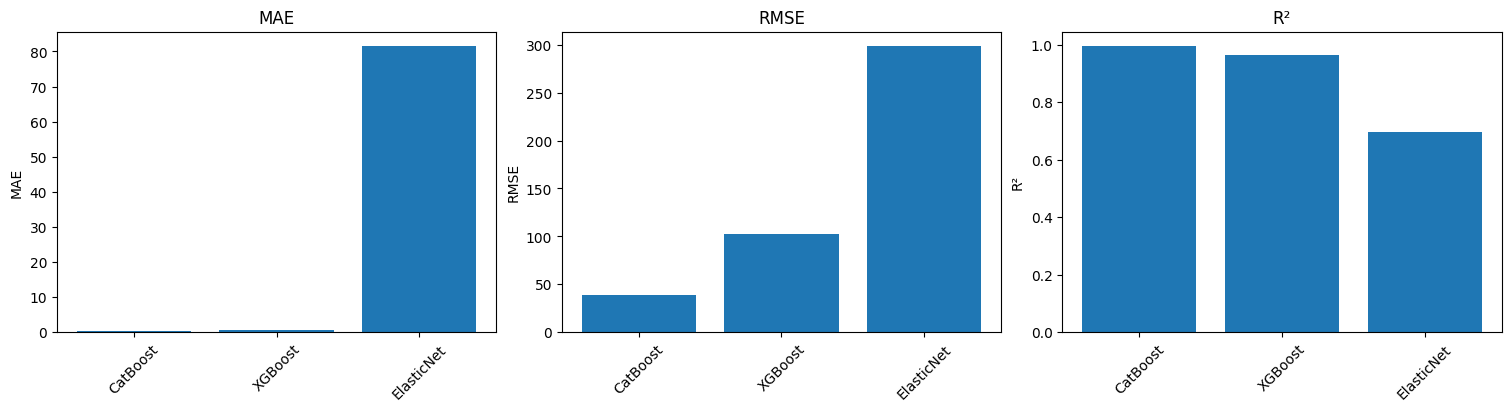

In [104]:
# Comparação de Métricas
models = ["CatBoost", "XGBoost", "ElasticNet"]
maes   = [mean_absolute_error(y_val, p) for p in [y_pred_cb, y_pred_xgb, y_pred_en]]
rmses  = [np.sqrt(mean_squared_error(y_val, p)) for p in [y_pred_cb, y_pred_xgb, y_pred_en]]
r2s    = [r2_score(y_val, p) for p in [y_pred_cb, y_pred_xgb, y_pred_en]]

x = np.arange(len(models))

fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# MAE
axes[0].bar(x, maes)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45)
axes[0].set_title("MAE")
axes[0].set_ylabel("MAE")

# RMSE
axes[1].bar(x, rmses)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45)
axes[1].set_title("RMSE")
axes[1].set_ylabel("RMSE")

# R²
axes[2].bar(x, r2s)
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=45)
axes[2].set_title("R²")
axes[2].set_ylabel("R²")

plt.show()

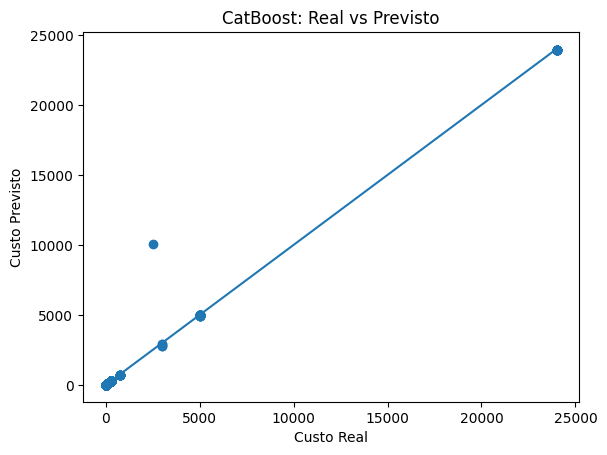

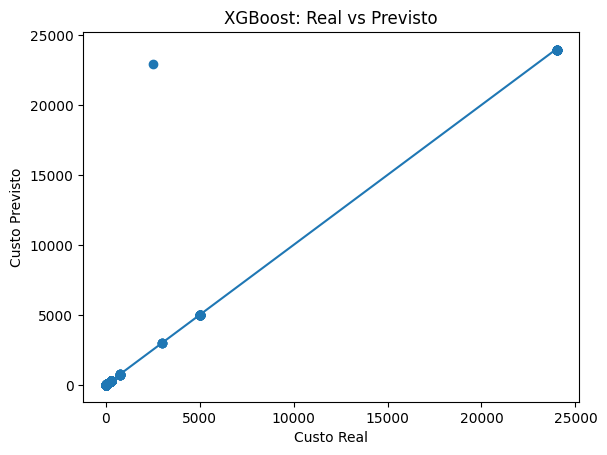

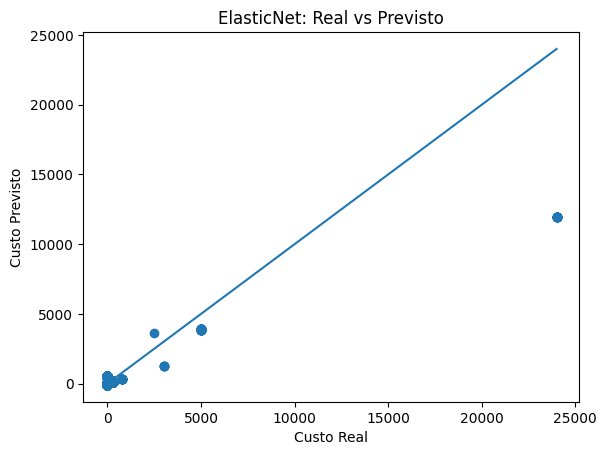

In [105]:
# Scatter Plot: Real vs Previsto
for name, y_pred in zip(models, preds):
    plt.figure()
    plt.scatter(y_val, y_pred)
    lims = [min(y_val.min(), y_pred.min()), max(y_val.max(), y_pred.max())]
    plt.plot(lims, lims)
    plt.xlabel("Custo Real")
    plt.ylabel("Custo Previsto")
    plt.title(f"{name}: Real vs Previsto")
    plt.show()


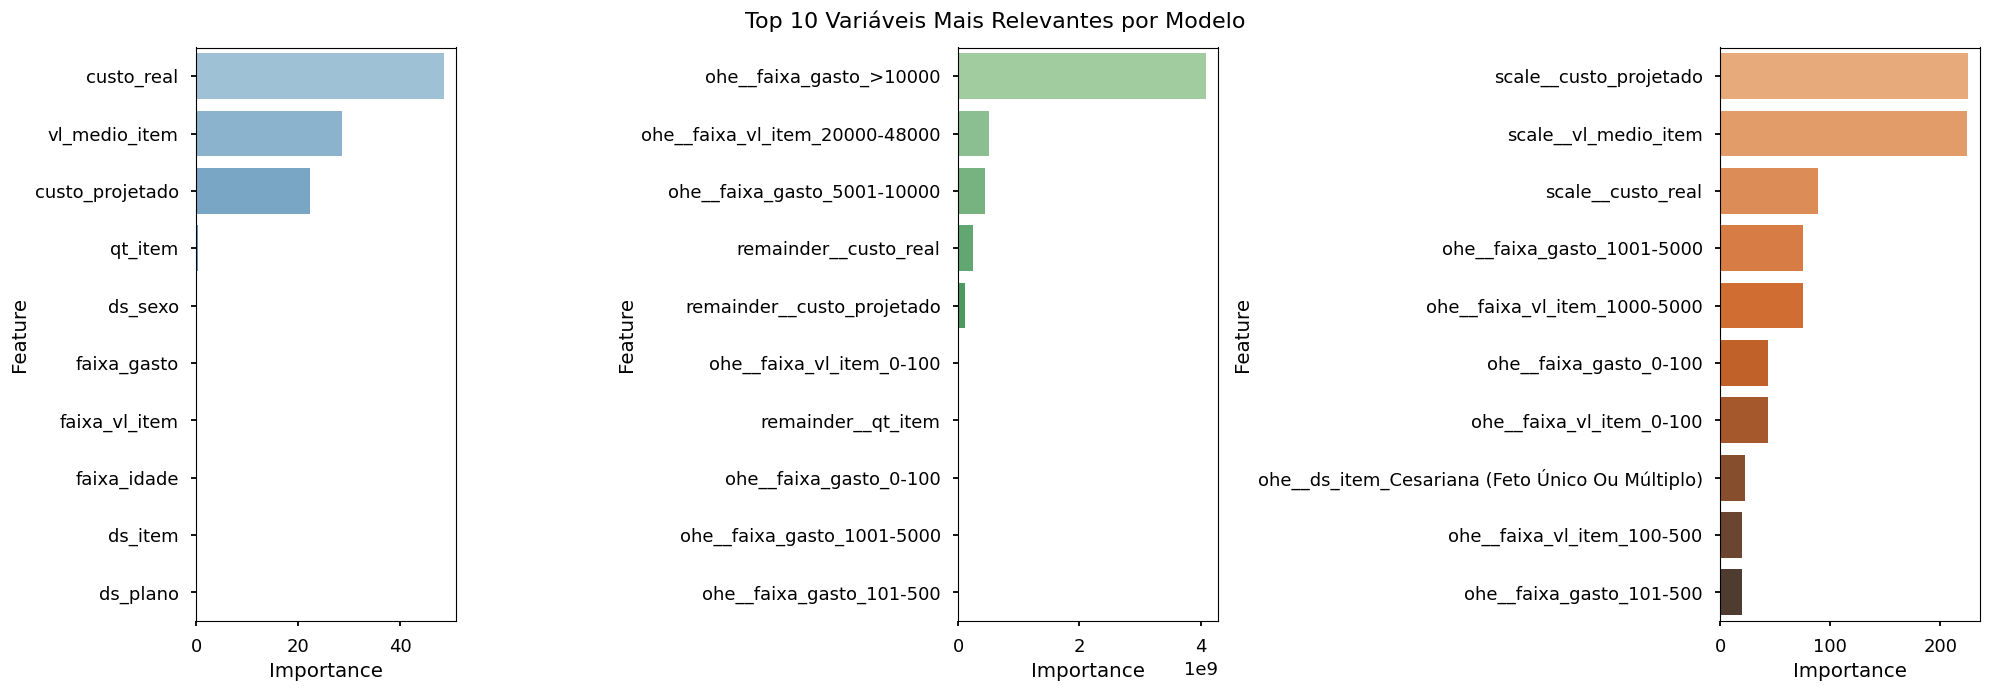

In [226]:
# Feature Importance
# ========== 1. CATBOOST ==========
cat_features_df = pd.DataFrame({
    "Feature": model_cb.feature_names_,
    "Importance": model_cb.get_feature_importance()
})
cat_features_df = cat_features_df.sort_values(by="Importance", ascending=False).head(10)


# ========== 2. XGBOOST ==========
# Get feature names from the OneHotEncoder pipeline
xgb_feature_names = pre_xgb.get_feature_names_out()

# Importance by gain
xgb_importance = bst.get_score(importance_type='gain')

# Map "f0", "f1", ... to actual feature names
xgb_importance_mapped = {
    xgb_feature_names[int(k[1:])]: v for k, v in xgb_importance.items()
}

xgb_features_df = pd.DataFrame(
    list(xgb_importance_mapped.items()), columns=["Feature", "Importance"]
)
xgb_features_df = xgb_features_df.sort_values(by="Importance", ascending=False).head(10)


# ========== 3. ELASTICNET ==========
# Fit preprocessor alone to get feature names
preprocessor_en.fit(X_train)
feature_names_en = preprocessor_en.get_feature_names_out()

# Fit full pipeline
pipeline_en.fit(X_train, y_train)
en_model = pipeline_en.named_steps["en"]
coef = en_model.coef_

df_en_imp = pd.DataFrame({
    "Feature": feature_names_en,
    "Importance": np.abs(coef)
})
df_en_imp = df_en_imp.sort_values(by="Importance", ascending=False).head(10)


# ========== 4. PLOT ==========
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=False)

# CatBoost
sns.barplot(
    data=cat_features_df,
    y="Feature", x="Importance",
    ax=axes[0],
    palette="Blues_d",
    hue="Feature", legend=False  # <- Adicionado para suprimir o warning
)

# XGBoost
sns.barplot(
    data=xgb_features_df,
    y="Feature", x="Importance",
    ax=axes[1],
    palette="Greens_d",
    hue="Feature", legend=False
)

# ElasticNet
sns.barplot(
    data=df_en_imp,
    y="Feature", x="Importance",
    ax=axes[2],
    palette="Oranges_d",
    hue="Feature", legend=False
)

# Ajustes finais
plt.suptitle("Top 10 Variáveis Mais Relevantes por Modelo", fontsize=16)
plt.tight_layout()
plt.show()

#### Conclusão da predição de custo evitado

##### CatBoost — Melhor desempenho geral
- MAE (Erro absoluto médio): muito baixo (quase zero)

- RMSE (Raiz do erro quadrático médio): também muito baixo

- R²: quase 1.00, o que indica que o modelo explica quase toda a variância do custo evitado

Conclusão: CatBoost fez previsões muito próximas dos valores reais. É, disparado, o melhor modelo entre os três.

##### XGBoost — Desempenho razoável
- MAE e RMSE: um pouco maiores que CatBoost, mas ainda baixos (relativamente)

- R²: próximo de 0.97, o que ainda é excelente

Conclusão: XGBoost também tem ótimo desempenho, embora um pouco inferior ao CatBoost. Pode ser uma boa alternativa dependendo da complexidade, tempo de treino, ou interpretabilidade.

##### ElasticNet — Desempenho fraco
- MAE: ~82 (alto)

- RMSE: ~300 (muito alto comparado aos outros)

- R²: ~0.70, ou seja, explica apenas 70% da variância

Conclusão: ElasticNet teve dificuldade em capturar padrões não lineares ou interações presentes nos dados. Foi muito inferior aos modelos de gradient boosting.

##### Resumo
| Modelo         | Qualidade | Resumo                                             |
| -------------- | --------- | -------------------------------------------------- |
| **CatBoost**   | Alta     | Melhor desempenho geral, previsões quase perfeitas |
| **XGBoost**    | Alta      | Muito bom, mas um pouco atrás do CatBoost          |
| **ElasticNet** | Baixa        | Simples e rápido, mas muito menos preciso          |

## Resultados obtidos

Apresentar de forma descritiva e em gráficos respondendo as questões solicitadas pela UNIMED

In [ ]:
# Bibliotecas para mostrar os resultados
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve

### Doença

O modelo Random Forest é a melhor escolha para este problema. Ele não só apresenta o melhor equilíbrio geral (F1-Score), mas também a maior capacidade de encontrar os pacientes que precisam de atenção (Recall), que é o principal objetivo do projeto.

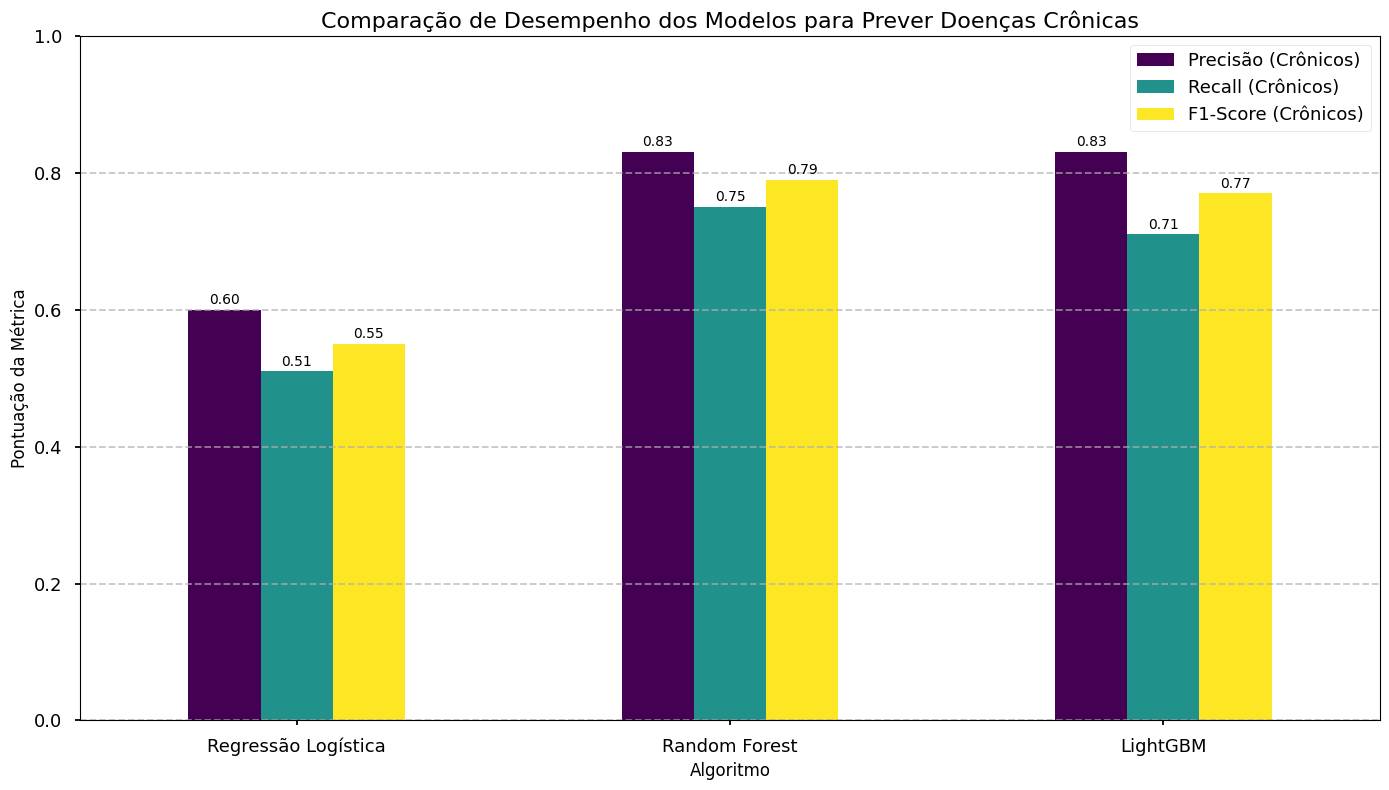

In [260]:
# CÓDIGO PARA GERAR OS GRÁFICOS

# Dados extraídos dos seus relatórios
data = {
    'Modelo': ['Regressão Logística', 'Random Forest', 'LightGBM'],
    'Precisão (Crônicos)': [0.60, 0.83, 0.83],
    'Recall (Crônicos)': [0.51, 0.75, 0.71],
    'F1-Score (Crônicos)': [0.55, 0.79, 0.77]
}
results_df = pd.DataFrame(data)

# Gráfico de Barras
results_df.set_index('Modelo').plot(
    kind='bar',
    figsize=(14, 8),
    rot=0,
    colormap='viridis'
)
plt.title('Comparação de Desempenho dos Modelos para Prever Doenças Crônicas', fontsize=16)
plt.ylabel('Pontuação da Métrica', fontsize=12)
plt.xlabel('Algoritmo', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.2f', label_type='edge', padding=2)
plt.tight_layout()
plt.show()

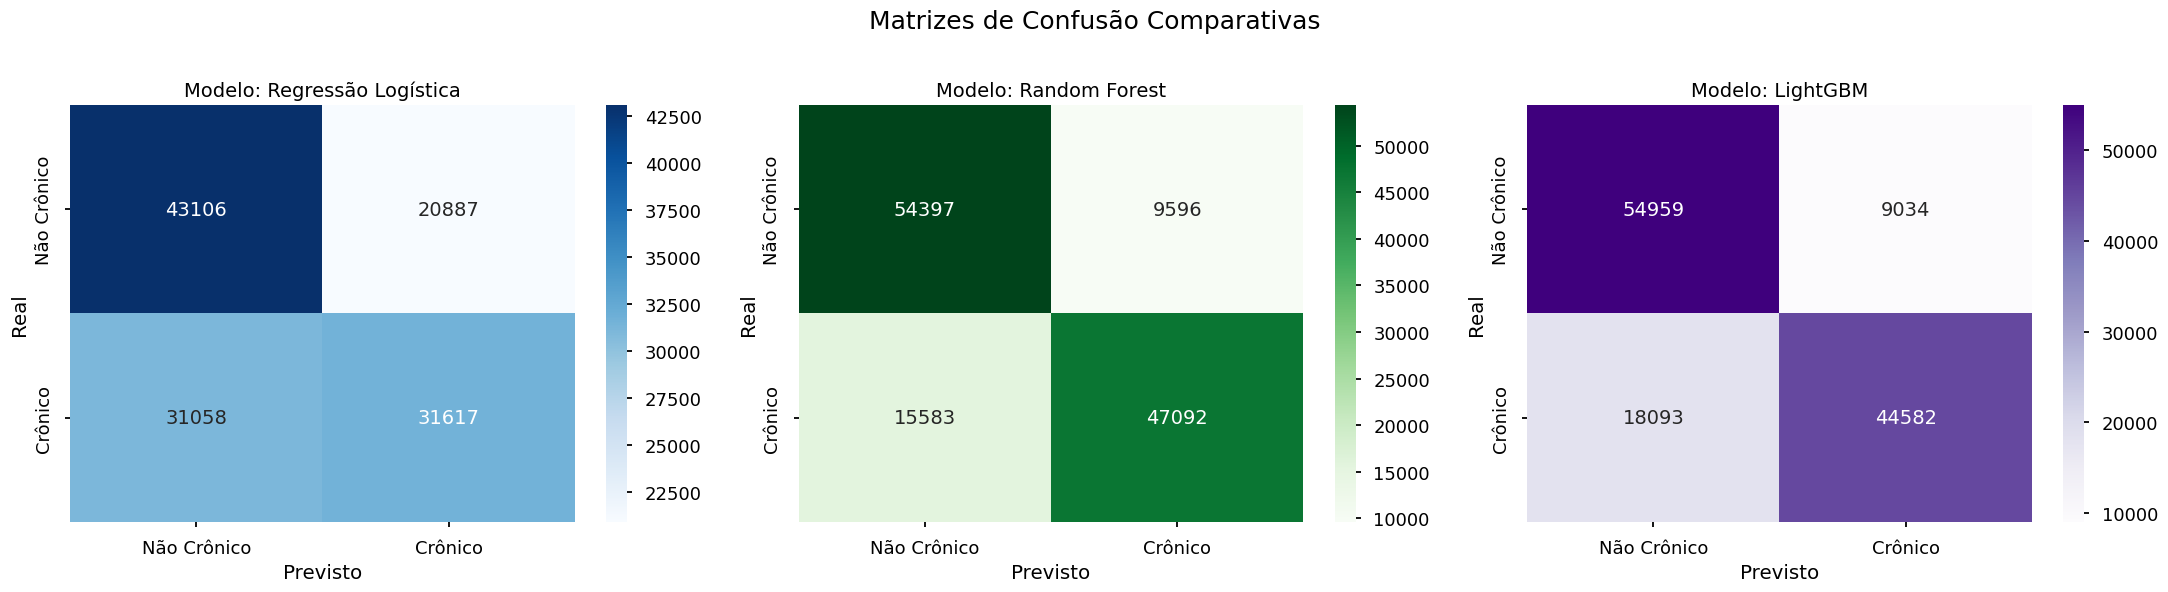

In [261]:
# CÓDIGO PARA GERAR AS MATRIZES DE CONFUSÃO
# Recriando as predições (y_pred_lr, y_pred_rf, y_pred_lgbm)


fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Matrizes de Confusão Comparativas', fontsize=18)

# Dicionários de modelos e predições para o loop
models_preds = {
    'Regressão Logística': y_pred_lr,
    'Random Forest': y_pred_rf,
    'LightGBM': y_pred_lgbm
}
colors = ['Blues', 'Greens', 'Purples']

for ax, model_name, color in zip(axes, models_preds.keys(), colors):
    pred = models_preds[model_name]
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, ax=ax, annot=True, fmt='d', cmap=color,
                xticklabels=['Não Crônico', 'Crônico'],
                yticklabels=['Não Crônico', 'Crônico'],
                annot_kws={"size": 14})
    ax.set_title(f'Modelo: {model_name}', fontsize=14)
    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Esses gráficos confirmam visualmente a superioridade dos modelos baseados em árvore (Random Forest e LightGBM) e destacam o Random Forest como a opção mais equilibrada e com maior poder de detecção para este desafio.

### Custo

#### Distribuição do custo evitado por linha de cuidado

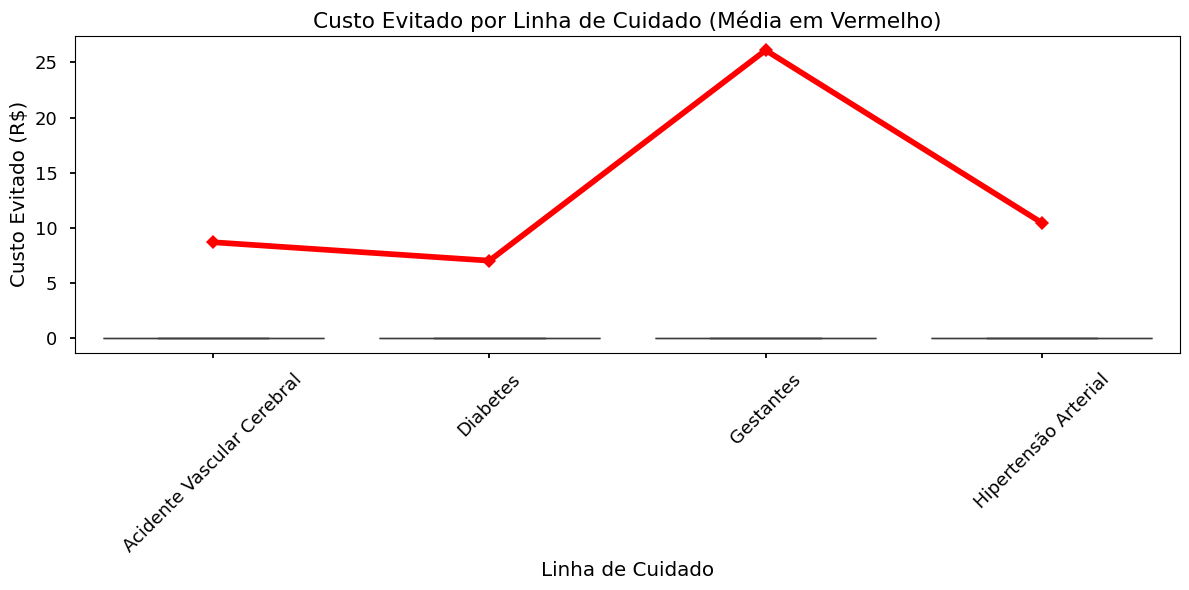

In [179]:
plt.figure(figsize=(12,6))
sns.boxplot(data=custo, x="ds_linha_cuidado_x", y="custo_evitado", showfliers=False)
sns.pointplot(data=custo, x="ds_linha_cuidado_x", y="custo_evitado", 
              color='red', markers='D', markersize=4, errorbar=None)
plt.xticks(rotation=45)
plt.title("Custo Evitado por Linha de Cuidado (Média em Vermelho)")
plt.ylabel("Custo Evitado (R$)")
plt.xlabel("Linha de Cuidado")
plt.tight_layout()
plt.show()

##### Conclusão
- A linha "Gestantes" tem a maior média de custo evitado, bem acima das demais.
- As linhas de "Hipertensão Arterial", "Diabetes" e "AVC" têm médias semelhantes e menores.
- Os boxplots são estreitos e colapsados, sugerindo que a maioria dos dados tem pouca variação ou valores muito baixos (talvez até nulos).

#### Média de custo evitado por faixa de idade

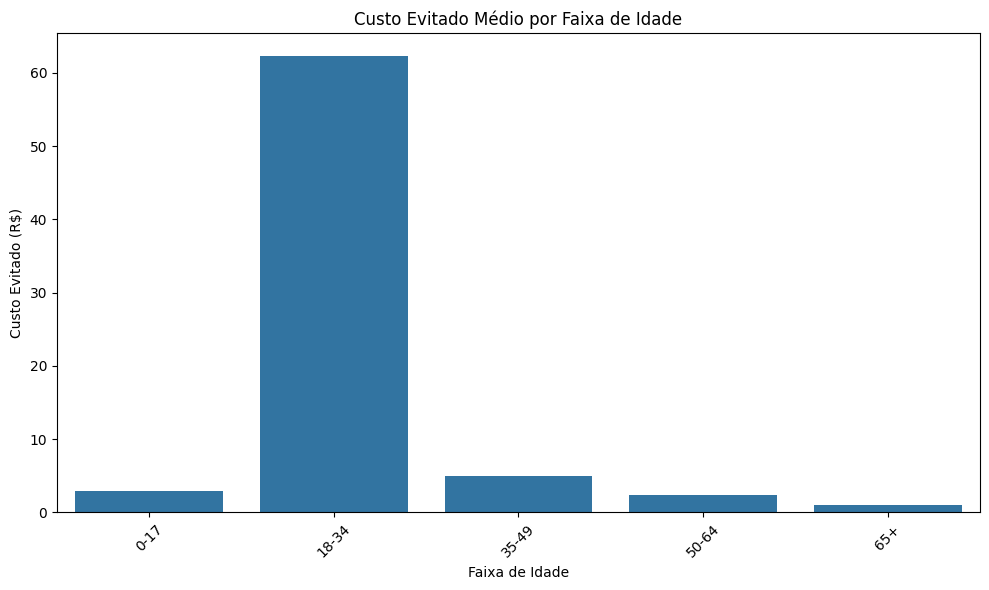

In [127]:
plt.figure(figsize=(10,6))
sns.barplot(data=custo, x="faixa_idade", y="custo_evitado", estimator="mean", errorbar=None)
plt.title("Custo Evitado Médio por Faixa de Idade")
plt.ylabel("Custo Evitado (R$)")
plt.xlabel("Faixa de Idade")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Conclusão
- O grupo de jovens adultos se beneficia mais de intervenções que evitam custos, talvez por aderirem mais a programas de prevenção ou por terem maior risco de doenças evitáveis nessa fase.
- Idosos (65+) têm o menor custo evitado, o que pode indicar menor efetividade preventiva nessa população ou dificuldade de acesso/adesão.

#### Custo real vs. projetado (antes e depois da linha de cuidado)

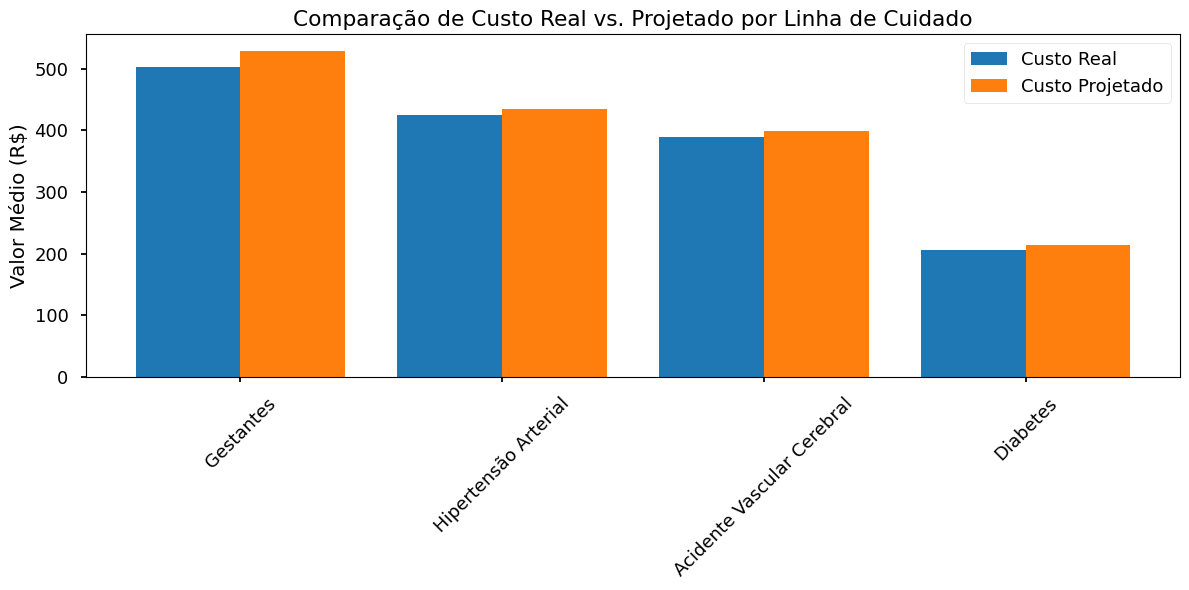

In [181]:
agg = custo.groupby("ds_linha_cuidado_x", observed=True)[["custo_real", "custo_projetado"]].mean().reset_index()
agg = agg.sort_values("custo_real", ascending=False)

plt.figure(figsize=(12,6))
x = range(len(agg))
plt.bar(x, agg["custo_real"], width=0.4, label="Custo Real", align='center')
plt.bar([i + 0.4 for i in x], agg["custo_projetado"], width=0.4, label="Custo Projetado", align='center')
plt.xticks([i + 0.2 for i in x], agg["ds_linha_cuidado_x"], rotation=45)
plt.ylabel("Valor Médio (R$)")
plt.title("Comparação de Custo Real vs. Projetado por Linha de Cuidado")
plt.legend()
plt.tight_layout()
plt.show()

##### Conclusão
- Em todas as linhas, o custo projetado é maior do que o custo real.
- As ações nas linhas de cuidado estão gerando economia efetiva em todas as áreas analisadas.
- O impacto mais significativo é novamente observado na linha das Gestantes.
- A menor diferença é em Diabetes, indicando ganho mais modesto.

#### Top doenças com maior custo evitado

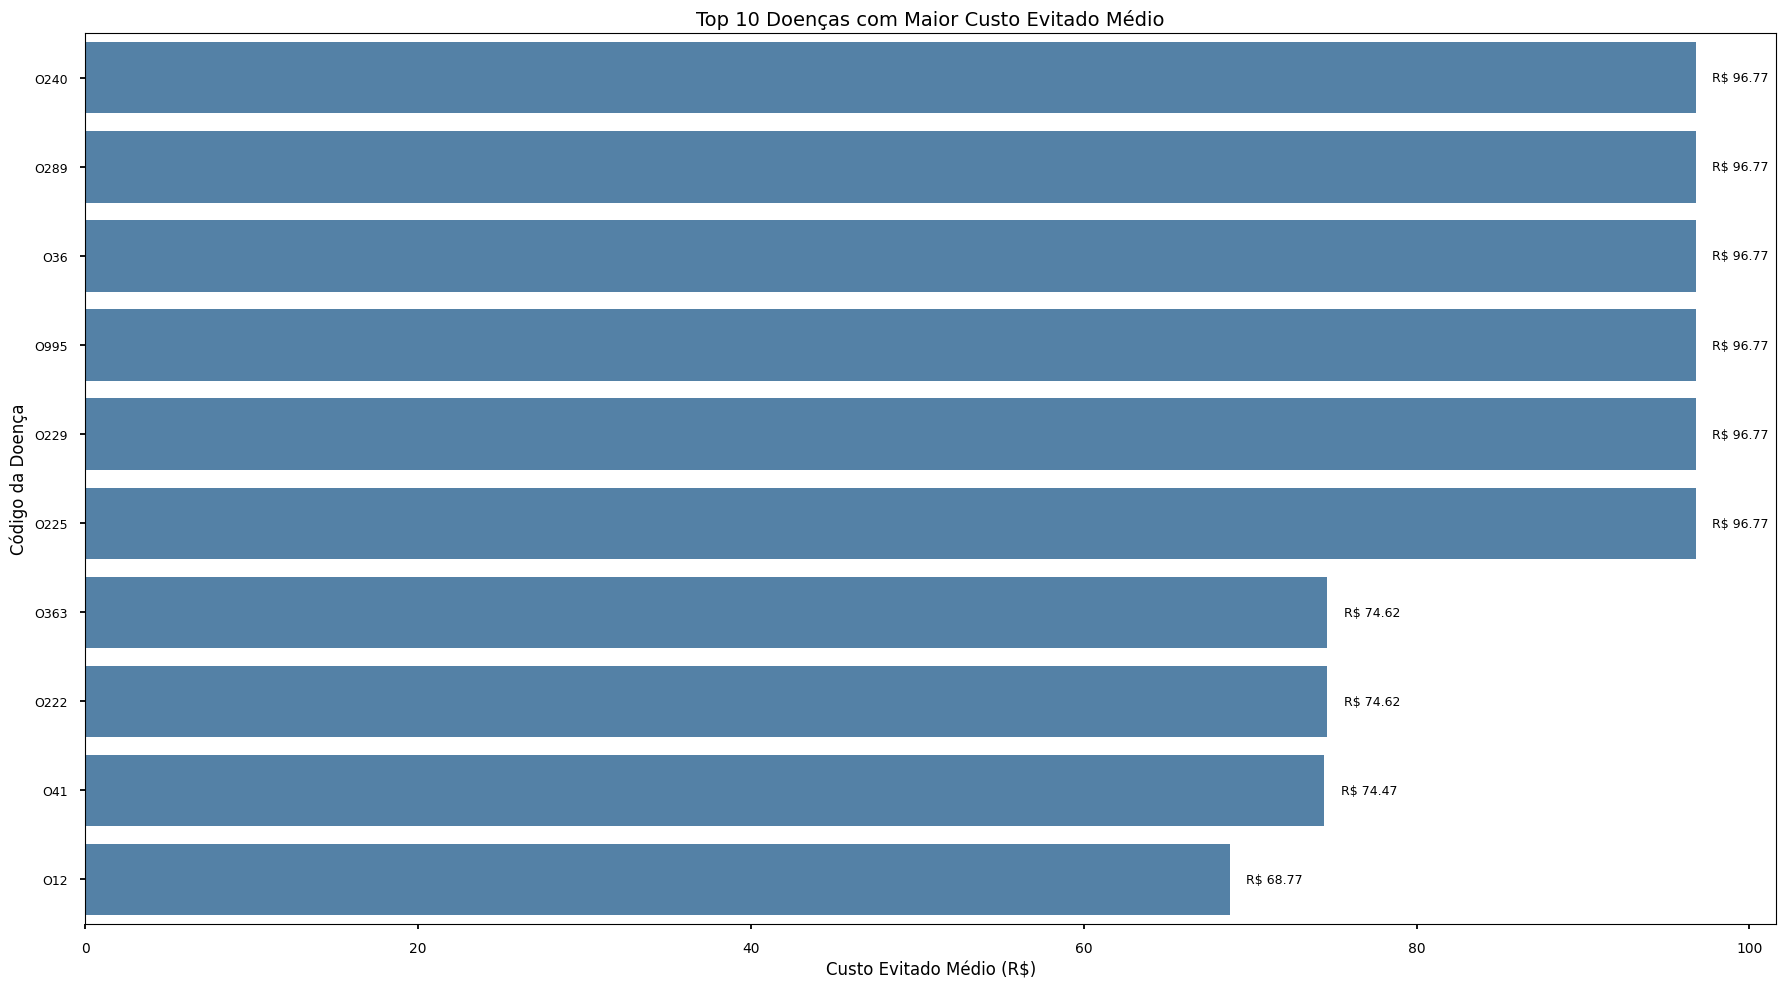

In [175]:
top_doencas = custo.groupby("cd_doenca", observed=True)["custo_evitado"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(18, 10))
ax = sns.barplot(
    x=top_doencas.values,
    y=top_doencas.index.astype(str),
    orient="h",
    color="steelblue"
)

# Adiciona os rótulos nas barras com melhor posicionamento
for i, v in enumerate(top_doencas.values):
    ax.text(v + 1, i, f"R$ {v:.2f}", va='center', fontsize=9)

plt.title("Top 10 Doenças com Maior Custo Evitado Médio", fontsize=14)
plt.xlabel("Custo Evitado Médio (R$)", fontsize=12)
plt.ylabel("Código da Doença", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()

##### Conclusão
- A maioria dos CIDs com maior custo evitado parece estar relacionada a gestação/parto.
- Isso confirma os achados anteriores: intervenções na linha de cuidado Gestantes são altamente efetivas em termos de economia.

#### Resumo Final
| Área                       | Insight principal                                                     |
| -------------------------- | --------------------------------------------------------------------- |
| Linha de Cuidado           | Gestantes lideram em custo evitado médio e impacto real vs. previsto. |
| Faixa Etária               | Adultos jovens (18–34) têm maior benefício médio das ações.           |
| Comparação de custos       | Em todas as linhas há economia, mas varia em intensidade.             |
| Doenças com maior economia | Doenças obstétricas dominam o top 10 em custo evitado médio.          |
